In [1]:
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend
import wandb
from wandb.keras import WandbCallback

In [2]:
from encoders import EncoderResNet18, encoderCNN
from decoders import DecoderResNet18, decoderCNN
from datasets import data_loader
from embedding import embedding
from reconstructions import reconstructions
from generations import Generations
from activations import VisualizeActivations
from src.CVAE import CVAE

backend.clear_session()

In [3]:
# TO DO: this should be passed as arguments
dataset_name = 'cifar10'
model_name = 'CVAE_resent'
kl_coefficient = .65
encoded_dim = 128
learning_rate = 0.0001 
epoch_count = 2
batch_size = 100
patience = 5

In [4]:
#TO DO: move datasets in the repo and change root_folder

train_x, test_x, val_x, train_y, test_y, val_y, train_y_one_hot, test_y_one_hot, val_y_one_hot, input_shape, category_count, labels = data_loader(name=dataset_name,
                                                                                                                                     root_folder='/home/PERSONALE/nicolas.derus2/HistoDL/datasets/')

In [5]:

wandb.init(project="HistoDL", entity="nrderus",
  config = {
  "dataset": dataset_name,
  "model": model_name,
  "encoded_dim": encoded_dim,
  "kl_coefficient": kl_coefficient,
  "learning_rate": learning_rate,
  "epochs": epoch_count,
  "batch_size": batch_size,
  "patience": patience,
})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nrderus. Use `wandb login --relogin` to force relogin


In [6]:
if 'resnet' in model_name:
    encoder = EncoderResNet18(encoded_dim = encoded_dim)
    encoder = encoder.model(input_shape=(input_shape[0], input_shape[1], input_shape[2] + category_count))
else:
    encoder = encoderCNN(input_shape, category_count, encoded_dim)

encoder

2022-07-11 00:50:55.399250: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
if 'resnet' in model_name:
    decoder = DecoderResNet18( encoded_dim = encoded_dim)
    decoder = decoder.model(input_shape=(encoded_dim + category_count,))
else:
    decoder = decoderCNN(input_shape, category_count, encoded_dim)

decoder

In [8]:
#kl_coefficient = encoded_dim / (input_shape[0] * input_shape[1] * input_shape[2]) # from b vae paper, use beta = encoded_dimension / pixel_dimension i.e. -> 0.068
print('kl coefficient: {:.3f}'.format(kl_coefficient))
cvae = CVAE(encoder, decoder, kl_coefficient, input_shape)
cvae.built = True
cvae.summary()

kl coefficient: 0.650
Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 128),             4334320   
                              (None, 128)]                       
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2386787   
                                                                 
Total params: 6,721,123
Trainable params: 6,720,531
Non-trainable params: 592
_________________________________________________________________


In [9]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))

    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    with strategy.scope():
        cvae = CVAE(encoder, decoder, kl_coefficient, input_shape)
        cvae.built = True
        cvae_input = cvae.encoder.input[0]
        cvae_output = cvae.decoder.output
        mu = cvae.encoder.get_layer('mu').output
        log_var = cvae.encoder.get_layer('log_var').output

        opt = keras.optimizers.Adam(learning_rate = learning_rate)
        cvae.compile(optimizer = opt, run_eagerly=False)
except:
    cvae = CVAE(encoder, decoder, kl_coefficient, input_shape)
    cvae.built = True
    cvae_input = cvae.encoder.input[0]
    cvae_output = cvae.decoder.output
    mu = cvae.encoder.get_layer('mu').output
    log_var = cvae.encoder.get_layer('log_var').output


    opt = keras.optimizers.Adam(learning_rate = learning_rate)
    cvae.compile(optimizer = opt, run_eagerly=False)

In [10]:

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
             patience=patience, restore_best_weights=False)

history = cvae.fit([train_x, train_y_one_hot],
                   validation_data = ([val_x, val_y_one_hot],None),
                   epochs = epoch_count,
                   batch_size = batch_size,
                   callbacks=[early_stop, WandbCallback(save_model = False) ]) #save_weights_only -> ValueError: Unable to create dataset (name already exists)

wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/2
400/400 [==============================] - 72s 177ms/step - loss: 45.7221 - reconstruction_loss: 41.0744 - kl_loss: 4.6478 - loss_no_weights: 48.2248 - val_loss: 39.2423 - val_reconstruction_loss: 32.6244 - val_kl_loss: 6.6179 - val_loss_no_weights: 42.8058 - _timestamp: 1657493528.0000 - _runtime: 78.0000
Epoch 2/2
400/400 [==============================] - 70s 174ms/step - loss: 36.9489 - reconstruction_loss: 30.0548 - kl_loss: 6.8941 - loss_no_weights: 40.6610 - val_loss: 34.5150 - val_reconstruction_loss: 27.5189 - val_kl_loss: 6.9960 - val_loss_no_weights: 38.2821 - _timestamp: 1657493598.0000 - _runtime: 148.0000


In [11]:
_, input_label_train, train_input = cvae.conditional_input([train_x, train_y_one_hot])
_, input_label_test, test_input = cvae.conditional_input([test_x, test_y_one_hot])
_, input_label_val, val_input = cvae.conditional_input([val_x, val_y_one_hot])

train_x_mean, train_log_var = cvae.encoder.predict(train_input)
test_x_mean, test_log_var = cvae.encoder.predict(test_input)
val_x_mean, val_log_var = cvae.encoder.predict(val_input)

/home/PERSONALE/nicolas.derus2/miniconda3/envs/H-VAE/lib/python3.9/site-packages/matplotlib/collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


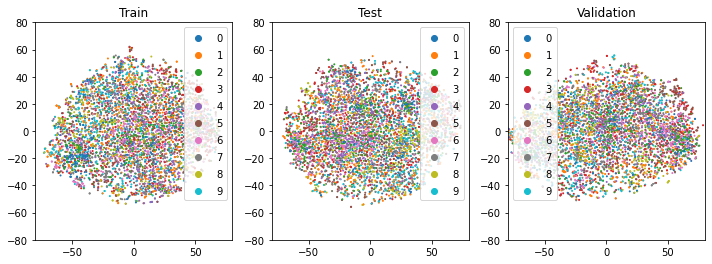

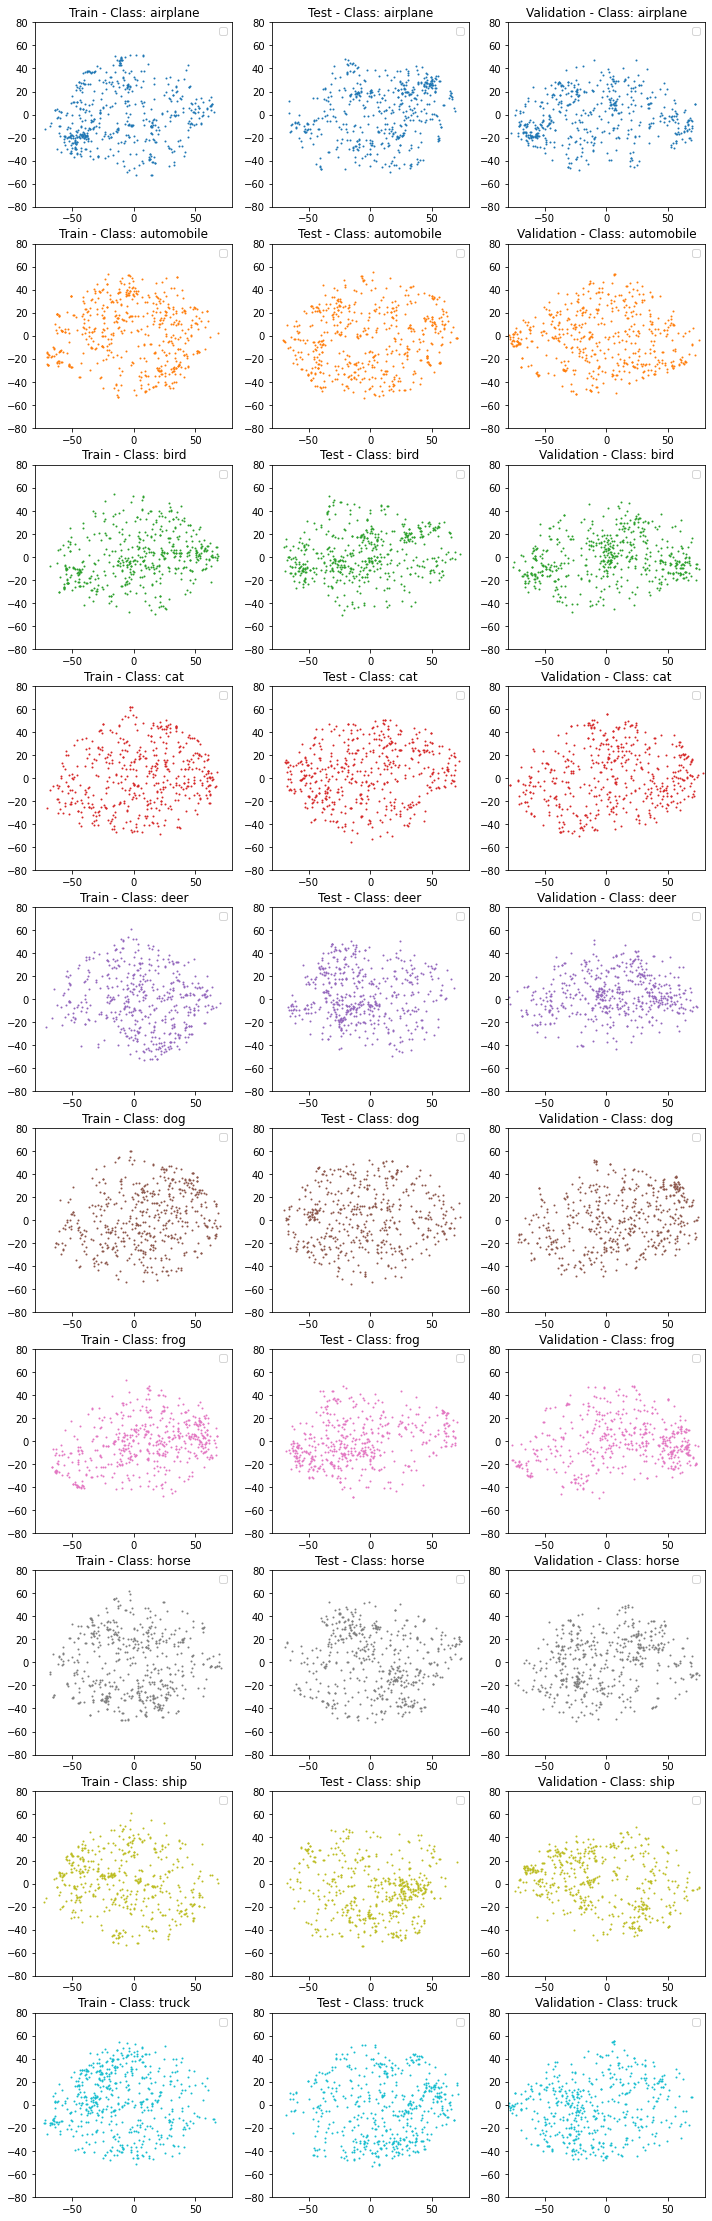

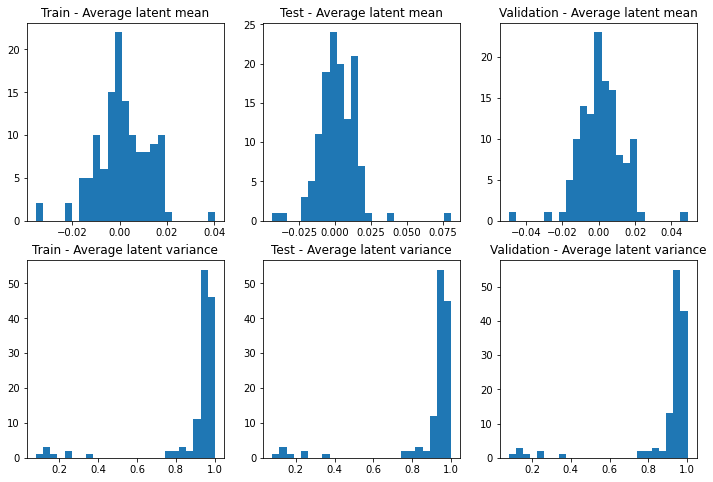

In [12]:
embedding(encoded_dim, category_count, train_x_mean, test_x_mean, val_x_mean, train_y, test_y, val_y, train_log_var, test_log_var, val_log_var, labels, xy_lim = 80, quantity = 5000, avg_latent=True)

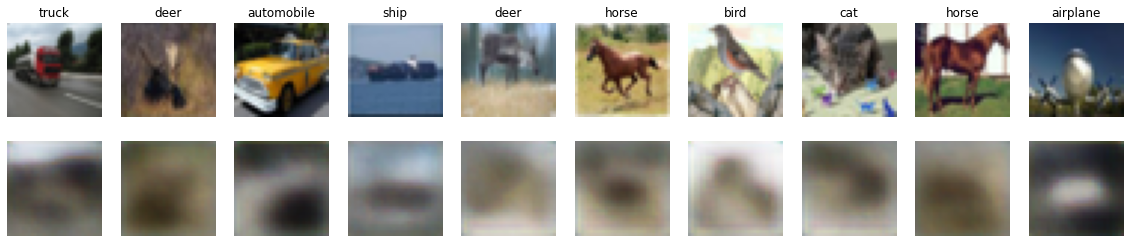

In [13]:
reconstructions(cvae, train_x, train_y, train_x_mean, train_log_var, input_label_train, labels)

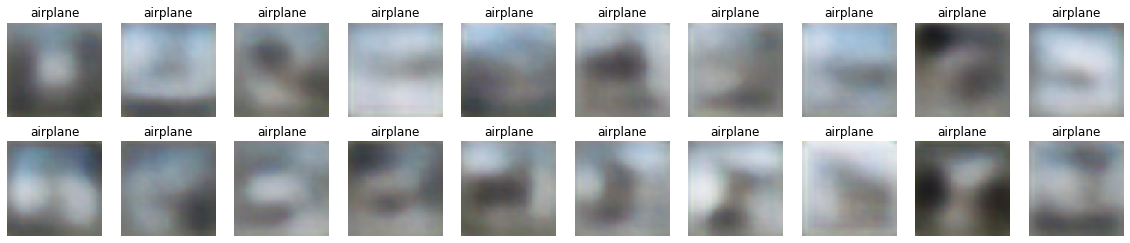

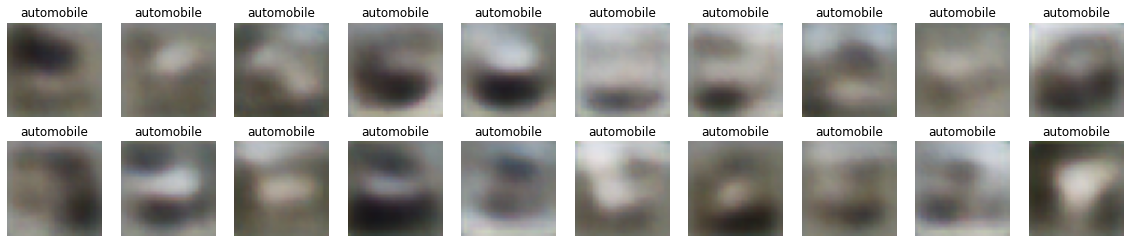

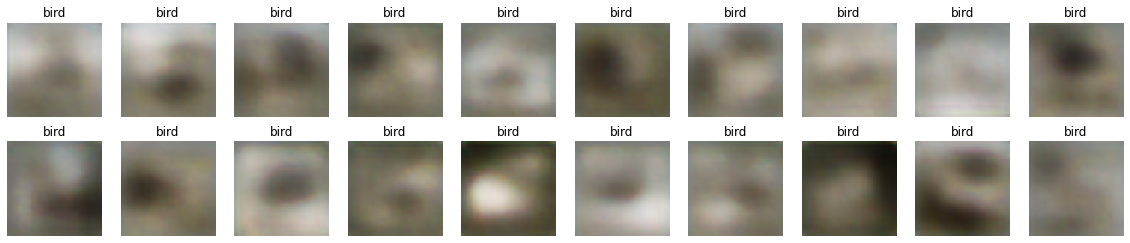

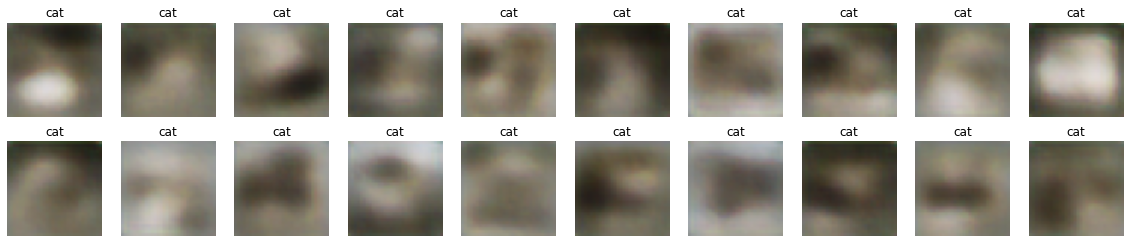

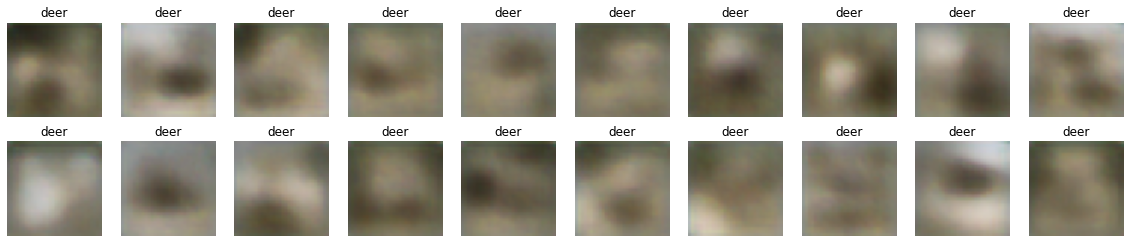

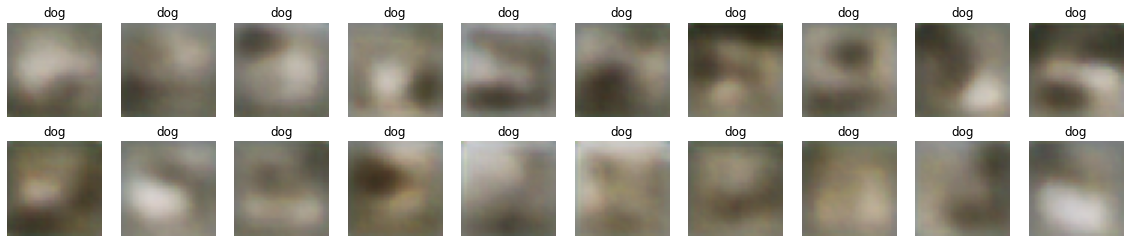

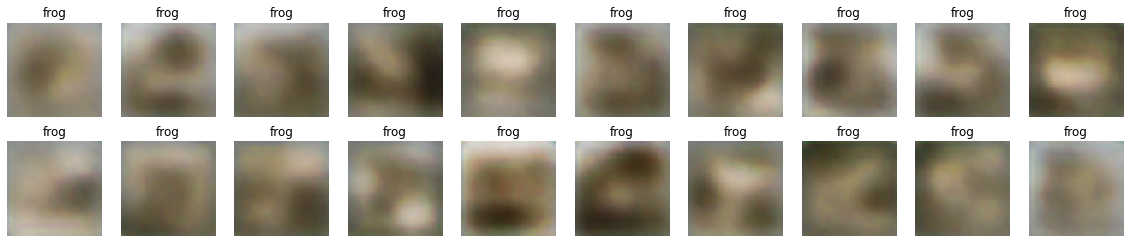

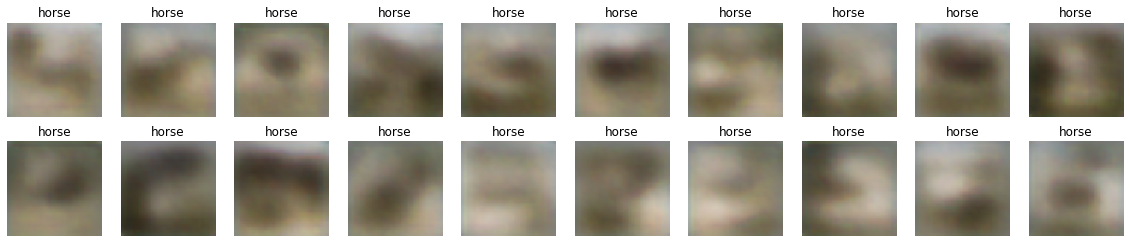

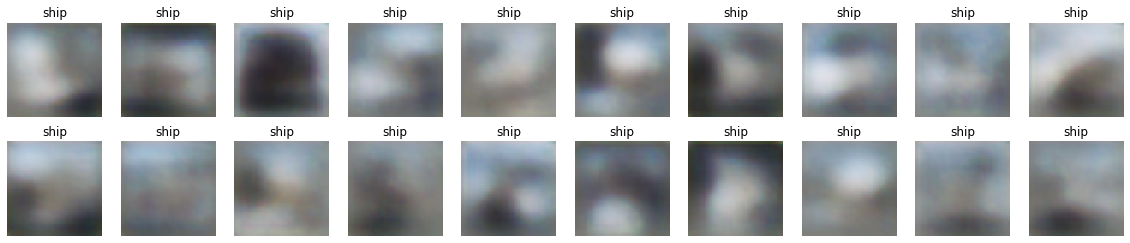

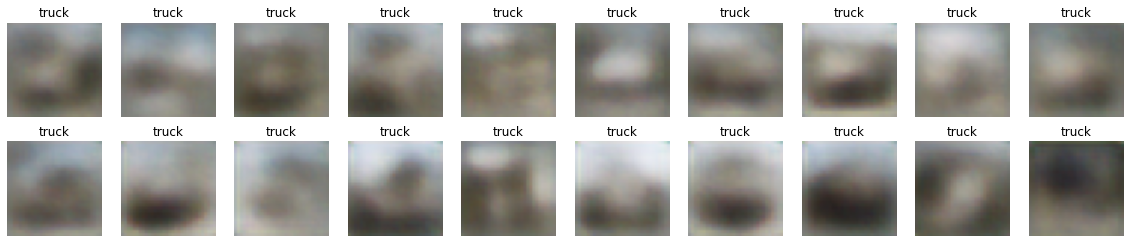

In [14]:
generator = Generations(cvae, encoded_dim, category_count, input_shape, labels)
generator()

In [15]:
#activations
activations = VisualizeActivations(cvae, test_x, test_y_one_hot)
activations()

In [16]:
#filters